>>>>> STARTING TEST 0 <<<<<


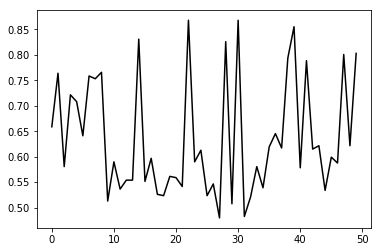

Average RMSE:  0.636243088529
Standard Deviation:  0.112989672593
Variance:  0.0127666661126
>>>>> END OF TEST 0 <<<<<
>>>>> STARTING TEST 1 <<<<<


C:\Users\Convidado\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


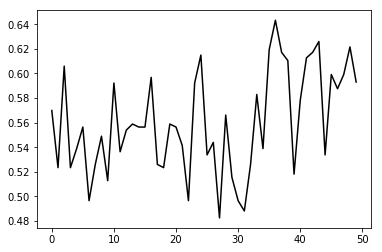

Average RMSE:  0.560273946897
Standard Deviation:  0.0412615573554
Variance:  0.00170251611539
>>>>> END OF TEST 1 <<<<<


In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import mixture
from sklearn.neighbors.kde import KernelDensity
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from math import sqrt


def pca(X, numComponents):
    pca = PCA(n_components=numComponents)
    pca.fit(X)
    PCA(copy=True, iterated_power='auto', n_components=numComponents, random_state=None, svd_solver='auto', tol=0.0, whiten=False)
    
    return pca.transform(X)
       
    
def kMeans(X, classes):  
    numClasses = len(classes)
    kmeans = KMeans(n_clusters=numClasses).fit(X)
    
    return kmeans


def svmClassifier(X, y):
    clf = svm.SVC()
    clf.fit(X, y)
    
    svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False)
    
    return clf
    

def gmm(points):
    clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
    pdfs = np.exp(clf.fit(points).score_samples(points))
        
    return pdfs


def kde(points):
    kernel = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(points)
    pdfs = np.exp(kernel.score_samples(points))
    
    return pdfs


def baseClassifier(instancesToPredict, classifier):
    return classifier.predict(instancesToPredict)


def initializingData(X, y):
    c1=[]
    c2=[]
    for i in range(len(y)):
        if y[i]==0:
            c1.append(X[i])
        else:
            c2.append(X[i])
    
    return c1, c2
    
    
def loadDensitiesByClass(instances, indexesByClass, densityFunction):
    pdfsByClass = {}
    for c, indexes in indexesByClass.items():
        pdfs = [-1] * len(instances)
        points = instances[indexes]
        pdfsByPoints = densityFunction(points)
        a = 0
        for i in indexes:
            pdfs[i]=pdfsByPoints[a]
            a+=1
        pdfsByClass[c] = pdfs
        
    return pdfsByClass


#Slicing instances according to their inferred clusters
def slicingClusteredData(clusters, classes):
    indexes = {}
    for c in range(len(classes)):
        indexes[classes[c]]=[i for i in range(len(clusters)) if clusters[i] == c]
    
    return indexes


#Cutting data for next iteration
def compactingDataDensityBased(instances, densities, criteria):
    selectedInstances=[]
    
    for k in densities:
        arrPdf = densities[k]
        maxPDF = max(arrPdf)*criteria
        selectedInstances.append([instances[i] for i in range(len(arrPdf)) if arrPdf[i] != -1 and arrPdf[i] >= maxPDF ])
    
    return selectedInstances
    

def plotDistributions(distributions):
    i=0
    #ploting
    fig = plt.figure()
    handles = []
    colors = ['magenta', 'cyan']
    classes = ['cluster 1', 'cluster 2']
    ax = fig.add_subplot(121)
    
    for X in distributions:
        #reducing to 2-dimensional data
        x=pca(X, 2)
        
        handles.append(ax.scatter(x[:, 0], x[:, 1], color=colors[i], s=5, edgecolor='none'))
        i+=1
    
    ax.legend(handles, classes)
    
    plt.show()
    
    
def plotDistributionByClass(instances, indexesByClass):
    i=0
    #ploting
    fig = plt.figure()
    handles = []
    colors = ['magenta', 'cyan']
    classes = ['cluster 1', 'cluster 2']
    ax = fig.add_subplot(121)
    
    for c, indexes in indexesByClass.items():
        X = instances[indexes]
        #reducing to 2-dimensional data
        x=pca(X, 2)
        
        handles.append(ax.scatter(x[:, 0], x[:, 1], color=colors[i], s=5, edgecolor='none'))
        i+=1
    
    ax.legend(handles, classes)
    
    plt.show()
    
    
def evaluate(y_actual, y_predicted):
    rmse = sqrt(mean_squared_error(y_actual, y_predicted))
    #print("RMSE: ", rmse)
    return rmse
    
    
def plotAccuracy(arrRmse):
    c = range(len(arrRmse))
    fig = plt.figure()
    fig.add_subplot(122)
    ax = plt.axes()
    ax.plot(c, arrRmse, 'k')
    plt.show()


def test0(dataValues, dataLabels, densityFunction='gmm', excludingPercentage = 0.5, batches = 50, sizeOfBatch = 365, initialLabeledDataPerc=0.05):
    print(">>>>> STARTING TEST 0 <<<<<")
    sizeOfLabeledData = round((initialLabeledDataPerc)*sizeOfBatch)
    initialDataLength = sizeOfLabeledData
    finalDataLength = sizeOfBatch
    classes=[0, 1]
    arrRmse=[]
    
    # ***** Box 0 *****
    X = dataValues.loc[:initialDataLength].copy()
    X = X.values
    y = dataLabels.loc[:initialDataLength].copy()
    y = y.values
    X_class1, X_class2 = initializingData(X, y)
    
    #Starting the process
    for t in range(batches):
        #print("Step ",t+1)
        
        # ***** Box 1 *****
        X = np.vstack([X_class1, X_class2])
        U = dataValues.loc[initialDataLength:finalDataLength].copy()
        Ut = U.values
        #print("Selected unlabeled data: ", Ut)

        # ***** Box 2 *****
        kmeans = kMeans(pca(X, 2), classes)
        clusters = kmeans.labels_
        predicted = baseClassifier(pca(Ut, 2), kmeans)
        instances = np.vstack([X, Ut])
        indexesByClass = slicingClusteredData(np.hstack([clusters, predicted]), classes)       
        #Evaluating
        #print(len(instances), " Points")
        yt = dataLabels.loc[initialDataLength:finalDataLength].copy()
        yt = yt.values
        arrRmse.append(evaluate(yt, predicted))
        #plotDistributions([X_class1, X_class2])
        
        # ***** Box 3 *****
        pdfByClass=''
        if densityFunction == 'gmm':
            pdfByClass = loadDensitiesByClass(instances, indexesByClass, gmm)
        elif densityFunction == 'kde':
            pdfByClass = loadDensitiesByClass(instances, indexesByClass, kde)
        else:
            print ("Choose between 'gmm' or 'kde' function. Wrong name given: ", densityFunction)
            return 
        #Plotting data distribution by class
        #plotDistributionByClass(instances, indexesByClass)
        
        # ***** Box 4 *****
        instancesByDensity = []
        if densityFunction == 'gmm':
            instancesByDensity = compactingDataDensityBased(instances, pdfByClass, excludingPercentage)
        elif densityFunction == 'kde':
            instancesByDensity = compactingDataDensityBased(instances, pdfByClass, excludingPercentage)
        
        # ***** Box 5 *****
        X_class1 = instancesByDensity[0]
        X_class2 = instancesByDensity[1]
        initialDataLength=finalDataLength+1
        finalDataLength+=sizeOfBatch
        
    plotAccuracy(arrRmse)
    print("Average RMSE: ", np.mean(arrRmse))
    print("Standard Deviation: ", np.std(arrRmse))
    print("Variance: ", np.std(arrRmse)**2)
    print(">>>>> END OF TEST 0 <<<<<")
        

def test1(dataValues, dataLabels, classifier='kmeans', batches = 50, sizeOfBatch = 365, initialLabeledDataPerc=0.05):
    print(">>>>> STARTING TEST 1 <<<<<")
    sizeOfLabeledData = round((initialLabeledDataPerc)*sizeOfBatch)
    initialDataLength = sizeOfLabeledData
    finalDataLength = sizeOfBatch
    classes=[0, 1]
    
    X = dataValues.loc[:initialDataLength].copy()
    X = X.values
    y = dataLabels.loc[:initialDataLength].copy()
    y = y.values
    
    arrRmse = []
    
    for t in range(batches):
        #print("Step ",t+1)
        
        U = dataValues.loc[initialDataLength:finalDataLength].copy()
        Ut = U.values
        yt = dataLabels.loc[initialDataLength:finalDataLength].copy()
        yt = yt.values
        predicted=[]
        
        if classifier == 'kmeans':
            kmeans = kMeans(pca(X, 2), classes)
            predicted = baseClassifier(pca(Ut, 2), kmeans)
        elif classifier == 'svm':
            svmClf = svmClassifier(pca(X, 2), y)
            predicted = baseClassifier(pca(Ut, 2), svmClf)
        else:
            return
        
        arrRmse.append(evaluate(yt, predicted))
        initialDataLength=finalDataLength+1
        finalDataLength+=sizeOfBatch
        # keep a percentage from former distribution to train in next step 
        #X = Ut
        #y = yt
    
    plotAccuracy(arrRmse)
    print("Average RMSE: ", np.mean(arrRmse))
    print("Standard Deviation: ", np.std(arrRmse))
    print("Variance: ", np.std(arrRmse)**2)
    print(">>>>> END OF TEST 1 <<<<<")

    
def test2(dataValues, dataLabels):
    pass
    
    
def main():
    #current directory
    path = os.getcwd() 
    '''
    Reading NOAA dataset:
    Eight  features  (average temperature, minimum temperature, maximum temperature, dew
    point,  sea  level  pressure,  visibility,  average wind speed, maximum  wind  speed)
    are  used  to  determine  whether  each  day  experienced  rain  or no rain.
    '''
    dataValues = pd.read_csv(path+'\\noaa_data.csv',sep = ",")
    dataLabels = pd.read_csv(path+'\\noaa_label.csv',sep = ",")
    #Test sets: Predicting 365 instances by step. 50 steps. Starting labeled data with 5% of 365 instances.
    ''' 
    Test 0: 
    Two classes.
    K-Means + GMM / KDE
    '''
    test0(dataValues, dataLabels, 'gmm')
    '''
    Test 1:
    Two classes.
    K-Means / SVM
    '''
    test1(dataValues, dataLabels, 'svm')
    
    
    
main()

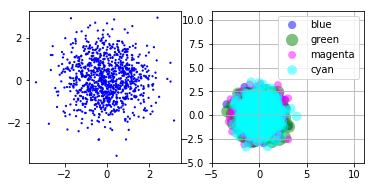

In [2]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax1 = fig.add_subplot(121)

## the data
N=1000
x = np.random.randn(N)
y = np.random.randn(N)

## left panel
ax1.scatter(x,y,color='blue',s=5,edgecolor='none')
ax1.set_aspect(1./ax1.get_data_ratio()) # make axes square


## right panel
ax2 = fig.add_subplot(122)
props = dict(alpha=0.5, edgecolors='none' )

handles = []
colors = ['blue', 'green', 'magenta', 'cyan']
for color in colors:
    x = np.random.randn(N)
    y = np.random.randn(N)
    s = np.random.randint(50,200)
    handles.append(ax2.scatter(x, y, c=color, s=s, **props))

ax2.set_ylim([-5,11])
ax2.set_xlim([-5,11])

ax2.legend(handles, colors)
ax2.grid(True)
ax2.set_aspect(1./ax2.get_data_ratio())
plt.show()